In [186]:
import numpy as np
import scipy.sparse as sp
import pandas as pd
from collections import namedtuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import matplotlib.pyplot as plt

# 数据准备 utils.py

In [187]:
Data = namedtuple('Data',['feature','label','adj','train_mask','val_mask','test_mask'])

class Cora():
    def __init__(self, path='./cora/', dataset='cora' ):
        self.path = path
        self.dataset = dataset

    #load_data()
    def process_data(self):
        print('Loading {} dataset...'.format(self.dataset))
        id_feature_label = np.genfromtxt("{path}{dataset}.content".format(path=self.path,dataset=self.dataset),
                                         dtype=np.dtype(str))

        feature =  np.array(id_feature_label[:,1:-1],dtype=np.float32)
        feature = feature / feature.sum(1, keepdims=True)

        label = np.array(pd.get_dummies(id_feature_label[:,-1]),dtype=np.int32)
        print(label)


        def sparse_mx_to_torch_sparse_tensor(sparse_mx):
            """将scipy稀疏矩阵转换成torch稀疏张量"""
            sparse_mx = sparse_mx.tocoo().astype(np.float32)
            # tocoo将此矩阵转换成coo格式，astype转换成数组的数据类型
            indices = torch.from_numpy(
                np.vstack((sparse_mx.row,sparse_mx.col)).astype(np.int64))
            # vstack 将两个数组垂直方向堆叠成一个新数组
            # from_numpy是将numpy中的ndarray转化成pytorch中的tensor
            # indices是coo的索引
            values = torch.from_numpy(sparse_mx.data)
            # values是coo的值
            shape = torch.Size(sparse_mx.shape)
            # coo的形状
            return torch.sparse.FloatTensor(indices,values,shape)
            # sparse.FloatTensor构造稀疏张量

        def normalize(adj):
            rowsum = np.array(adj.sum(1))
            r_inv = np.power(rowsum,-1).flatten()
            r_inv[np.isinf(r_inv)] = 0.

            r_mat_inv = sp.diags(r_inv)
            adj = r_mat_inv.dot(adj)
            return adj

        def sample_mask(index, length):
            mask = np.zeros(length)
            mask[index] = 1
            return np.array(mask,dtype=np.bool_)

        def build_adjcency(id_feature_label,label):
            id = np.array(id_feature_label[:,0],dtype=np.int32)
            id_map = {j:i for i,j in enumerate(id)}

            edges = np.genfromtxt("{path}{dataset}.cites".format(path=self.path,dataset=self.dataset),
                                  dtype=np.int32)

            edges_order_by_id = np.array(list(map(id_map.get, edges.flatten())),
                                         dtype=np.int32).reshape(edges.shape)

            row = edges_order_by_id[:,0]
            col = edges_order_by_id[:,1]
            data = np.ones(edges_order_by_id.shape[0])
            adj = sp.coo_matrix((data,(row,col)),
                                shape=(label.shape[0],label.shape[0]),
                                dtype=np.float32)
            return adj

        adj = build_adjcency(id_feature_label,label)
        # 构建对称邻接矩阵，计算转置矩阵，将有向图转化为无向图
        adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

        adj = normalize(adj)
        index_train = range(140) #0-139为训练集索引
        index_val = range(140, 640)
        index_test = range(1708, 2708)

        length = label.shape[0]

        train_mask = sample_mask(index_train, length)
        val_mask = sample_mask(index_val, length)
        test_mask = sample_mask(index_test, length)
        # train_mask = torch.LongTensor(index_train)
        # val_mask = torch.LongTensor(index_val)
        # test_mask = torch.LongTensor(index_test)
        print(feature.shape, type(feature))
        print(label.shape, type(label))
        print(adj.shape, type(adj))
        print(train_mask.shape, type(train_mask))
        print(val_mask.shape, type(val_mask))
        print(test_mask.shape, type(test_mask))

        feature = torch.from_numpy(np.array(feature))
        label = torch.LongTensor(np.where(label)[1])
        # np.where(label)[1]返回索引的下标值


        adj = sparse_mx_to_torch_sparse_tensor(adj)

        train_mask = torch.from_numpy(train_mask)
        val_mask = torch.from_numpy(val_mask)
        test_mask = torch.from_numpy(test_mask)

        return Data(feature,label,adj,train_mask,val_mask,test_mask)

# 图卷积层定义 layers.py

In [188]:
class GraphConvolution(nn.Module):
    "简单的gcn层"
    def __init__(self, input_dim, output_dim, use_bias=True):
        super(GraphConvolution, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.use_bias = use_bias
        self.weight = nn.Parameter(torch.Tensor(input_dim, output_dim))
        if self.use_bias:
            self.bias = nn.Parameter(torch.Tensor(output_dim))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight)
        if self.use_bias:
            init.zeros_(self.bias)

    def forward(self, adjacency, input_feature):
        support = torch.mm(input_feature, self.weight)
        output = torch.sparse.mm(adjacency, support)
        if self.use_bias:
            output += self.bias
        return output


    def __repr__(self): # 打印输出
        return self.__class__.__name__ + '(' \
               + str(self.in_features + '->' \
                     + str(self.out_features) + ')')
        # 打印形式 GraphConvolution(输入特征->输出特征)

# models.py

In [189]:
class GCN(nn.Module):
    def __init__(self, input_dim=1433):
        super(GCN, self).__init__()
        self.gcn1 = GraphConvolution(input_dim,16)
        self.gcn2 = GraphConvolution(16,7)
    def forward(self,adj,feature):
        h = F.relu(self.gcn1(adj,feature))
        # 训练神经网络模型时，如果训练样本较少，为了防止模型过拟合，Dropout可以作为一种trick供选择
        # Dropout是指在模型训练时,随机让网络某些隐含层节点的权重不工作，不工作的那些节点可以暂时认为不是网络结构的一部分，
        # 但是它的权重得保留下来（只是暂时不更新而已），因为下次样本输入时它可能又得工作了
        # 训练时用dropout(令trainning=True)，评估时关掉dropout(令trainning=False)
        logits = self.gcn2(adj,h)
        return logits

In [190]:
# 定义超参数
LEARNING_RATE = 0.1 # 学习率
WEIGHT_DACAY = 5e-4 # 权重衰减
EPOCHS = 200
DEVICE = 'cpu'

In [191]:
dataset = Cora().process_data()
feature = dataset.feature
label = dataset.label
adj = dataset.adj
train_mask = dataset.train_mask
val_mask = dataset.val_mask
test_mask = dataset.test_mask

# print(feature.shape, type(feature))
# print(label.shape, type(label))
# print(adj.shape, type(adj))
# print(train_mask.shape, type(train_mask))
# print(val_mask.shape, type(val_mask))
# print(test_mask.shape, type(test_mask))

input_dim = 1433

Loading cora dataset...
[[0 0 1 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 1 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]]
(2708, 1433) <class 'numpy.ndarray'>
(2708, 7) <class 'numpy.ndarray'>
(2708, 2708) <class 'scipy.sparse.csr.csr_matrix'>
(2708,) <class 'numpy.ndarray'>
(2708,) <class 'numpy.ndarray'>
(2708,) <class 'numpy.ndarray'>


In [193]:
model = GCN(input_dim).to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.Adam(model.parameters(), 
                       lr=LEARNING_RATE, 
                       weight_decay=WEIGHT_DACAY)

# train.py

In [194]:
def train():
    loss_history = []
    val_acc_history = []
    model.train()
    train_label = label[train_mask]
    for epoch in range(EPOCHS):
        logits = model(adj,feature) # logits相当于输出，过一遍模型
        train_mask_logits = logits[train_mask] # 只选择训练节点进行监督
        # train_mask 相当于 idx_train

        loss = criterion(train_mask_logits, train_label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_acc, _, _ = test(train_mask) #计算当前模型在训练集上的准确率
        val_acc, _, _ = test(val_mask) #计算当前模型在验证集上的准确率

        #记录训练过程中的损失loss和准确率变化，用于画图
        loss_history.append(loss.item())
        val_acc_history.append(val_acc.item())
        print("Epoch {:03d}: Loss {:.4f}, TrainAcc {:.4}, ValAcc {:.4f}".format(
            epoch, loss.item(), train_acc.item(), val_acc.item()))
    return loss_history, val_acc_history

In [195]:
def test(mask): # 相当于对已有的模型在测试集上运行对应的loss与accuracy
    model.eval()
    with torch.no_grad():
        output = model(adj, feature)
        test_mask_logits = output[mask]
        predict_y = test_mask_logits.max(1)[1]
        accuarcy = torch.eq(predict_y,label[mask]).float().mean()
    return accuarcy,test_mask_logits.cpu().numpy(), label[mask].cpu().numpy()

In [196]:
def plot_loss_with_acc(loss_history,val_acc_history):
    fig = plt.figure()

    ax1 = fig.add_subplot(111) # 画loss函数
    ax1.plot(range(len(loss_history)),loss_history,
             c=np.array([255, 71, 90]) / 255.) #c is color
    plt.ylabel('Loss')

    ax2 = fig.add_subplot(111, sharex=ax1, frameon=False)
    ax2.plot(range(len(val_acc_history)),val_acc_history,
             c=np.array([79, 179, 255]) / 255.)
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
    plt.ylabel("ValAcc")

    plt.xlabel("Epoch")
    plt.title('Training Loss & Validation Accuracy')
    plt.show()

In [197]:
loss, val_acc = train()
test_acc,test_logits,test_label = test(test_mask)
print("test accuarcy:",test_acc.item())

Epoch 000: Loss 1.9273, TrainAcc 0.3071, ValAcc 0.3500
Epoch 001: Loss 1.7273, TrainAcc 0.4214, ValAcc 0.3860
Epoch 002: Loss 1.6333, TrainAcc 0.4714, ValAcc 0.4420
Epoch 003: Loss 1.4864, TrainAcc 0.5071, ValAcc 0.4440
Epoch 004: Loss 1.3340, TrainAcc 0.6214, ValAcc 0.5360
Epoch 005: Loss 1.2068, TrainAcc 0.6714, ValAcc 0.5900
Epoch 006: Loss 1.0862, TrainAcc 0.7143, ValAcc 0.6100
Epoch 007: Loss 0.9564, TrainAcc 0.7429, ValAcc 0.6400
Epoch 008: Loss 0.8367, TrainAcc 0.7786, ValAcc 0.6800
Epoch 009: Loss 0.7361, TrainAcc 0.8429, ValAcc 0.7000
Epoch 010: Loss 0.6450, TrainAcc 0.8929, ValAcc 0.7160
Epoch 011: Loss 0.5599, TrainAcc 0.95, ValAcc 0.7460
Epoch 012: Loss 0.4854, TrainAcc 0.9643, ValAcc 0.8020
Epoch 013: Loss 0.4276, TrainAcc 0.9643, ValAcc 0.8020
Epoch 014: Loss 0.3815, TrainAcc 0.9714, ValAcc 0.8060
Epoch 015: Loss 0.3415, TrainAcc 0.9714, ValAcc 0.7980
Epoch 016: Loss 0.3097, TrainAcc 0.9786, ValAcc 0.7820
Epoch 017: Loss 0.2879, TrainAcc 0.9857, ValAcc 0.7840
Epoch 018: L

Epoch 149: Loss 0.1487, TrainAcc 0.9786, ValAcc 0.7920
Epoch 150: Loss 0.1489, TrainAcc 0.9857, ValAcc 0.7940
Epoch 151: Loss 0.1492, TrainAcc 0.9786, ValAcc 0.7920
Epoch 152: Loss 0.1493, TrainAcc 0.9857, ValAcc 0.7940
Epoch 153: Loss 0.1493, TrainAcc 0.9786, ValAcc 0.7920
Epoch 154: Loss 0.1491, TrainAcc 0.9857, ValAcc 0.7940
Epoch 155: Loss 0.1489, TrainAcc 0.9786, ValAcc 0.7940
Epoch 156: Loss 0.1487, TrainAcc 0.9857, ValAcc 0.7920
Epoch 157: Loss 0.1486, TrainAcc 0.9857, ValAcc 0.7940
Epoch 158: Loss 0.1486, TrainAcc 0.9786, ValAcc 0.7960
Epoch 159: Loss 0.1487, TrainAcc 0.9857, ValAcc 0.7920
Epoch 160: Loss 0.1489, TrainAcc 0.9786, ValAcc 0.7920
Epoch 161: Loss 0.1490, TrainAcc 0.9857, ValAcc 0.7940
Epoch 162: Loss 0.1491, TrainAcc 0.9786, ValAcc 0.7920
Epoch 163: Loss 0.1490, TrainAcc 0.9857, ValAcc 0.7940
Epoch 164: Loss 0.1490, TrainAcc 0.9786, ValAcc 0.7920
Epoch 165: Loss 0.1488, TrainAcc 0.9857, ValAcc 0.7940
Epoch 166: Loss 0.1488, TrainAcc 0.9786, ValAcc 0.7920
Epoch 167:

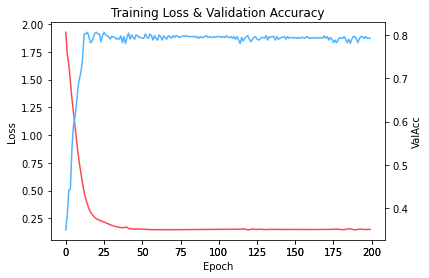

In [198]:
plot_loss_with_acc(loss,val_acc)

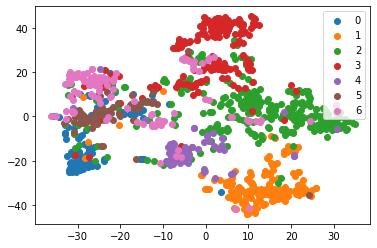

In [199]:
# 绘制测试数据的TSNE降维图
from sklearn.manifold import TSNE
tsne = TSNE()
out = tsne.fit_transform(test_logits)
fig = plt.figure()
for i in range(7):
    indices = test_label == i
    x, y = out[indices].T
    plt.scatter(x,y,label=str(i))
plt.legend()